# NixLaStats Forecast

## Loading Libraries

In [7]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Scikit-Learn
from sklearn.model_selection import train_test_split

# StatsForecast
import statsforecast
from statsforecast import StatsForecast
from statsforecast.utils import ConformalIntervals
from statsforecast.models import SeasonalExponentialSmoothing, ADIDA, ARIMA

# Data Visualization
import matplotlib.pyplot as plt

In [9]:
from statsforecast.models import (
    AutoETS,
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive
)

In [11]:
!pip show statsforecast

Name: statsforecast
Version: 2.0.1
Summary: Time series forecasting suite using statistical models
Home-page: https://github.com/Nixtla/statsforecast/
Author: Nixtla
Author-email: business@nixtla.io
License: Apache Software License 2.0
Location: /root/venv/lib/python3.10/site-packages
Requires: cloudpickle, coreforecast, fugue, numba, numpy, pandas, scipy, statsmodels, threadpoolctl, tqdm, utilsforecast
Required-by: 


In [13]:
import statsforecast.utils
dir(statsforecast.utils)

['AirPassengers',
 'AirPassengersDF',
 'CACHE',
 'ConformalIntervals',
 'DataFrame',
 'Dict',
 'NOGIL',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_calculate_intervals',
 '_calculate_sigma',
 '_ensure_float',
 '_naive',
 '_quantiles',
 '_repeat_val',
 '_repeat_val_seas',
 '_seasonal_naive',
 'generate_series',
 'math',
 'namedtuple',
 'njit',
 'norm',
 'np',
 'os',
 'pd',
 'restrict_to_bounds',
 'results',
 'utils_generate_series']

## Retreiving & Loading Dataset

- Using Hourly Dataset M4 Competition Convention

In [15]:
# Training Dataset
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')

# Test Dataset
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In [17]:
train.head()

unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

In [19]:
test.head()

unique_id   ds  y_test
0        H1  701   619.0
1        H1  702   565.0
2        H1  703   532.0
3        H1  704   495.0
4        H1  705   481.0

### Training Models

In [21]:
# Series Selection
n_series = 8

uids = train['unique_id'].unique()[:n_series] 
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

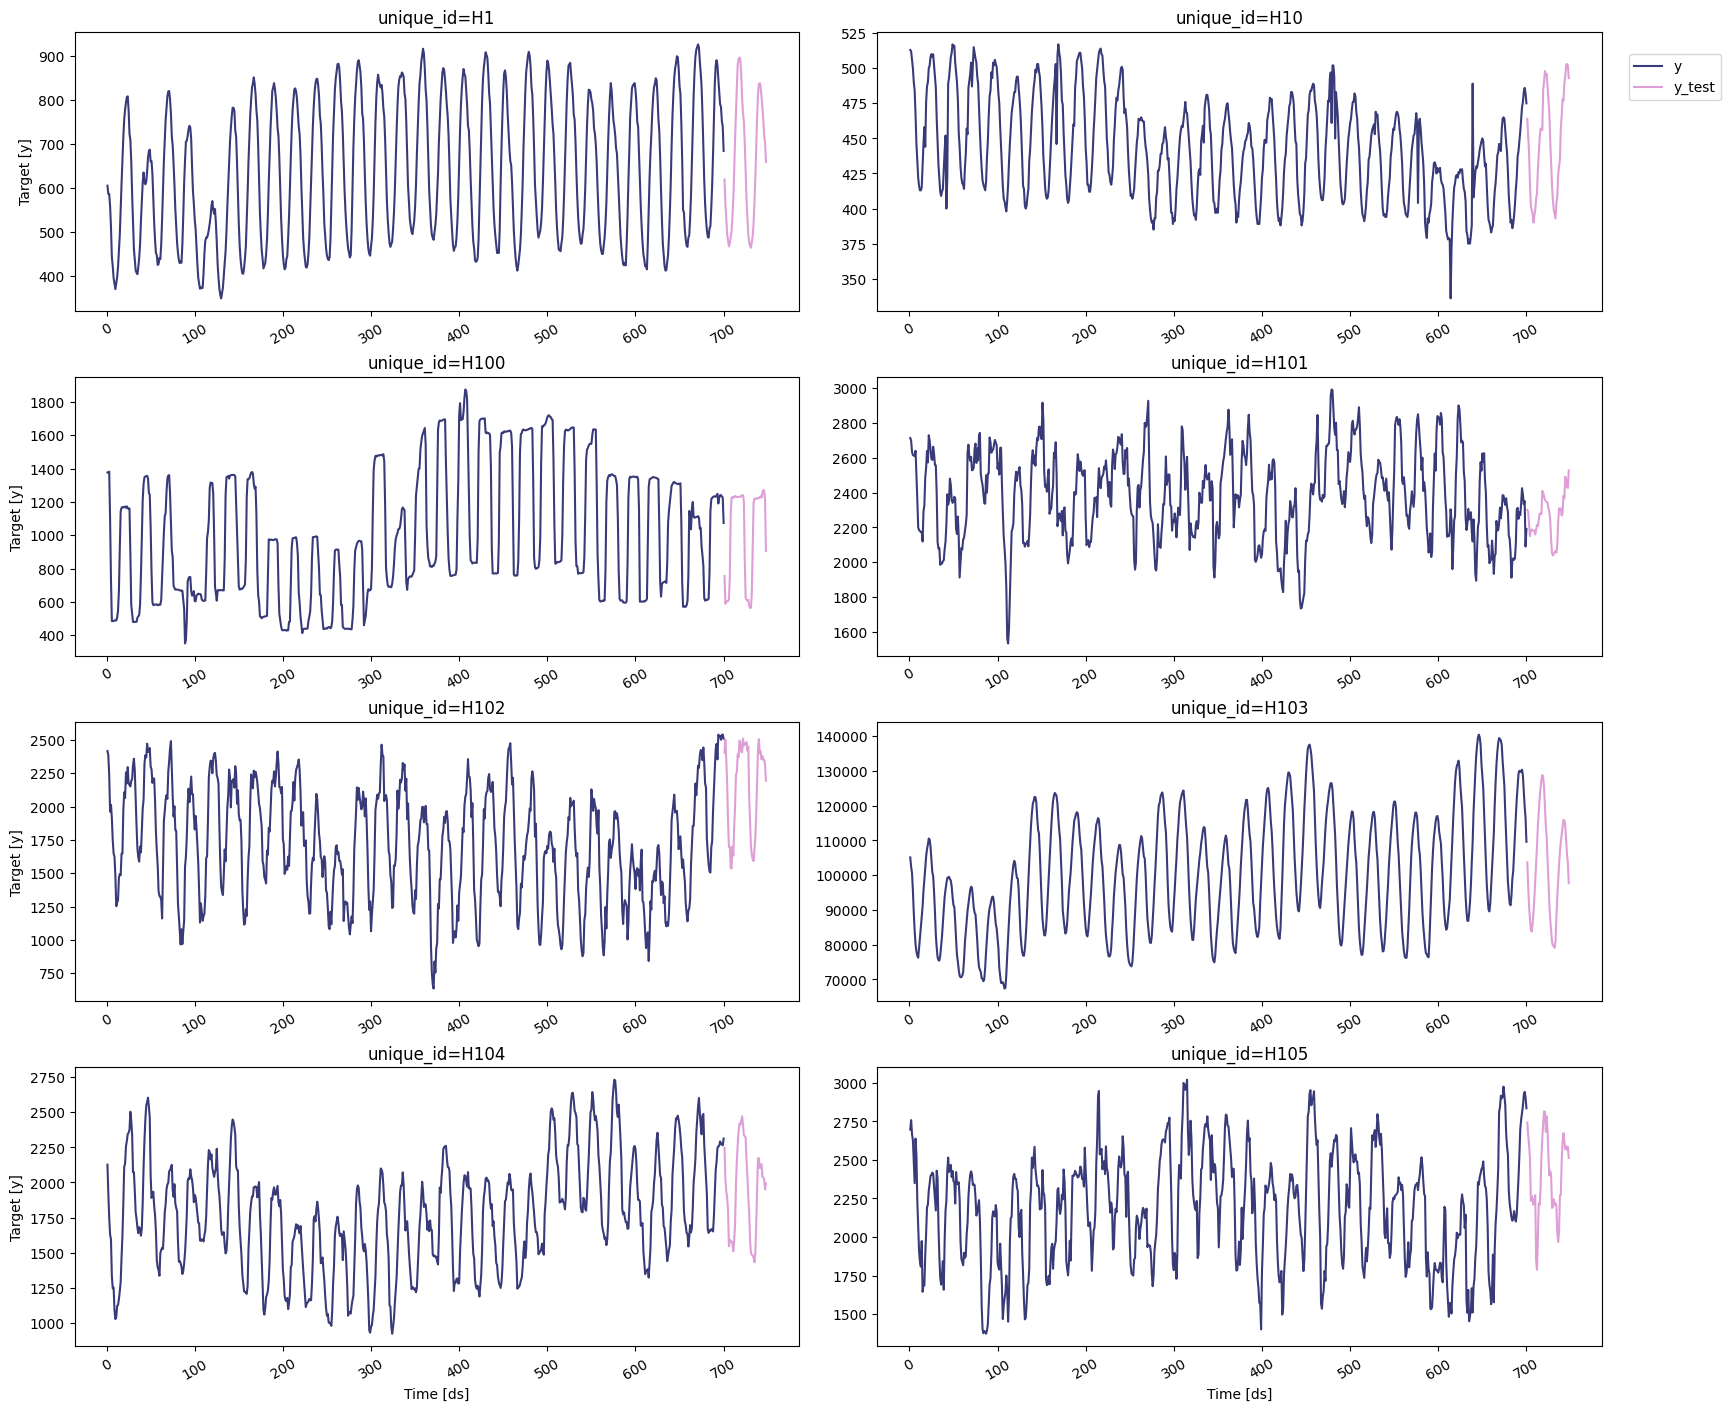

In [23]:
StatsForecast.plot(train, test, plot_random = False)

- Model Instantiation: Setting seasonal_length=24

In [25]:
models = [
    AutoETS(season_length=24),
    HistoricAverage(),
    Naive(),
    RandomWalkWithDrift(),
    SeasonalNaive(season_length=24)
]

In [49]:
# sf = StatsForecast(
#     df=train,
#     models=models,
#     freq='H',
#     n_jobs=-1
# )

In [95]:
from statsforecast import StatsForecast

sf = StatsForecast(
    models=models,
    freq=1, # Changing 'H' to '1'
    n_jobs=-1
)

In [97]:
# Prediction Intervals: Confidence Level
levels = [80, 90, 95, 99] 

# Create forecasts with integer frequency
forecasts = sf.forecast(df=train, h=48, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

index unique_id   ds     AutoETS  AutoETS-lo-99  AutoETS-lo-95  \
0      0        H1  701  631.889598     533.371822     556.926831   
1      1        H1  702  559.750830     460.738592     484.411824   
2      2        H1  703  519.235476     419.731233     443.522100   
3      3        H1  704  486.973364     386.979536     410.887460   
4      4        H1  705  464.697366     364.216339     388.240749   

   AutoETS-lo-90  AutoETS-lo-80  AutoETS-hi-80  AutoETS-hi-90  ...  \
0     568.978861     582.874079     680.905116     694.800335  ...   
1     496.524343     510.489302     609.012359     622.977317  ...   
2     455.694808     469.729161     568.741792     582.776145  ...   
3     423.120060     437.223465     536.723263     550.826668  ...   
4     400.532950     414.705071     514.689661     528.861782  ...   

    RWD-hi-99  SeasonalNaive  SeasonalNaive-lo-80  SeasonalNaive-lo-90  \
0  789.416619          691.0           613.351903           591.339747   
1  833.254152          618.0           540.351903           518.339747   
2  866.990616          563.0           485.351903           463.339747   
3  895.510095          529.0           451.351903           429.339747   
4  920.702904          504.0           426.351903           404.339747   

   SeasonalNaive-lo-95  SeasonalNaive-lo-99  SeasonalNaive-hi-80  \
0           572.247484           534.932739           768.648097   
1           499.247484           461.932739           695.648097   
2           444.247484           406.932739           640.648097   
3           410.247484           372.932739           606.648097   
4           385.247484           347.932739           581.648097   

   SeasonalNaive-hi-90  SeasonalNaive-hi-95  SeasonalNaive-hi-99  
0           790.660253           809.752516           847.067261  
1           717.660253           736.752516           774.067261  
2           662.660253           681.752516           719.067261  
3           628.660253           647.752516           685.067261  
4           603.660253           622.752516           660.067261  

[5 rows x 48 columns]

In [99]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

## Plotting: Prediction Intervals

### AutoETS

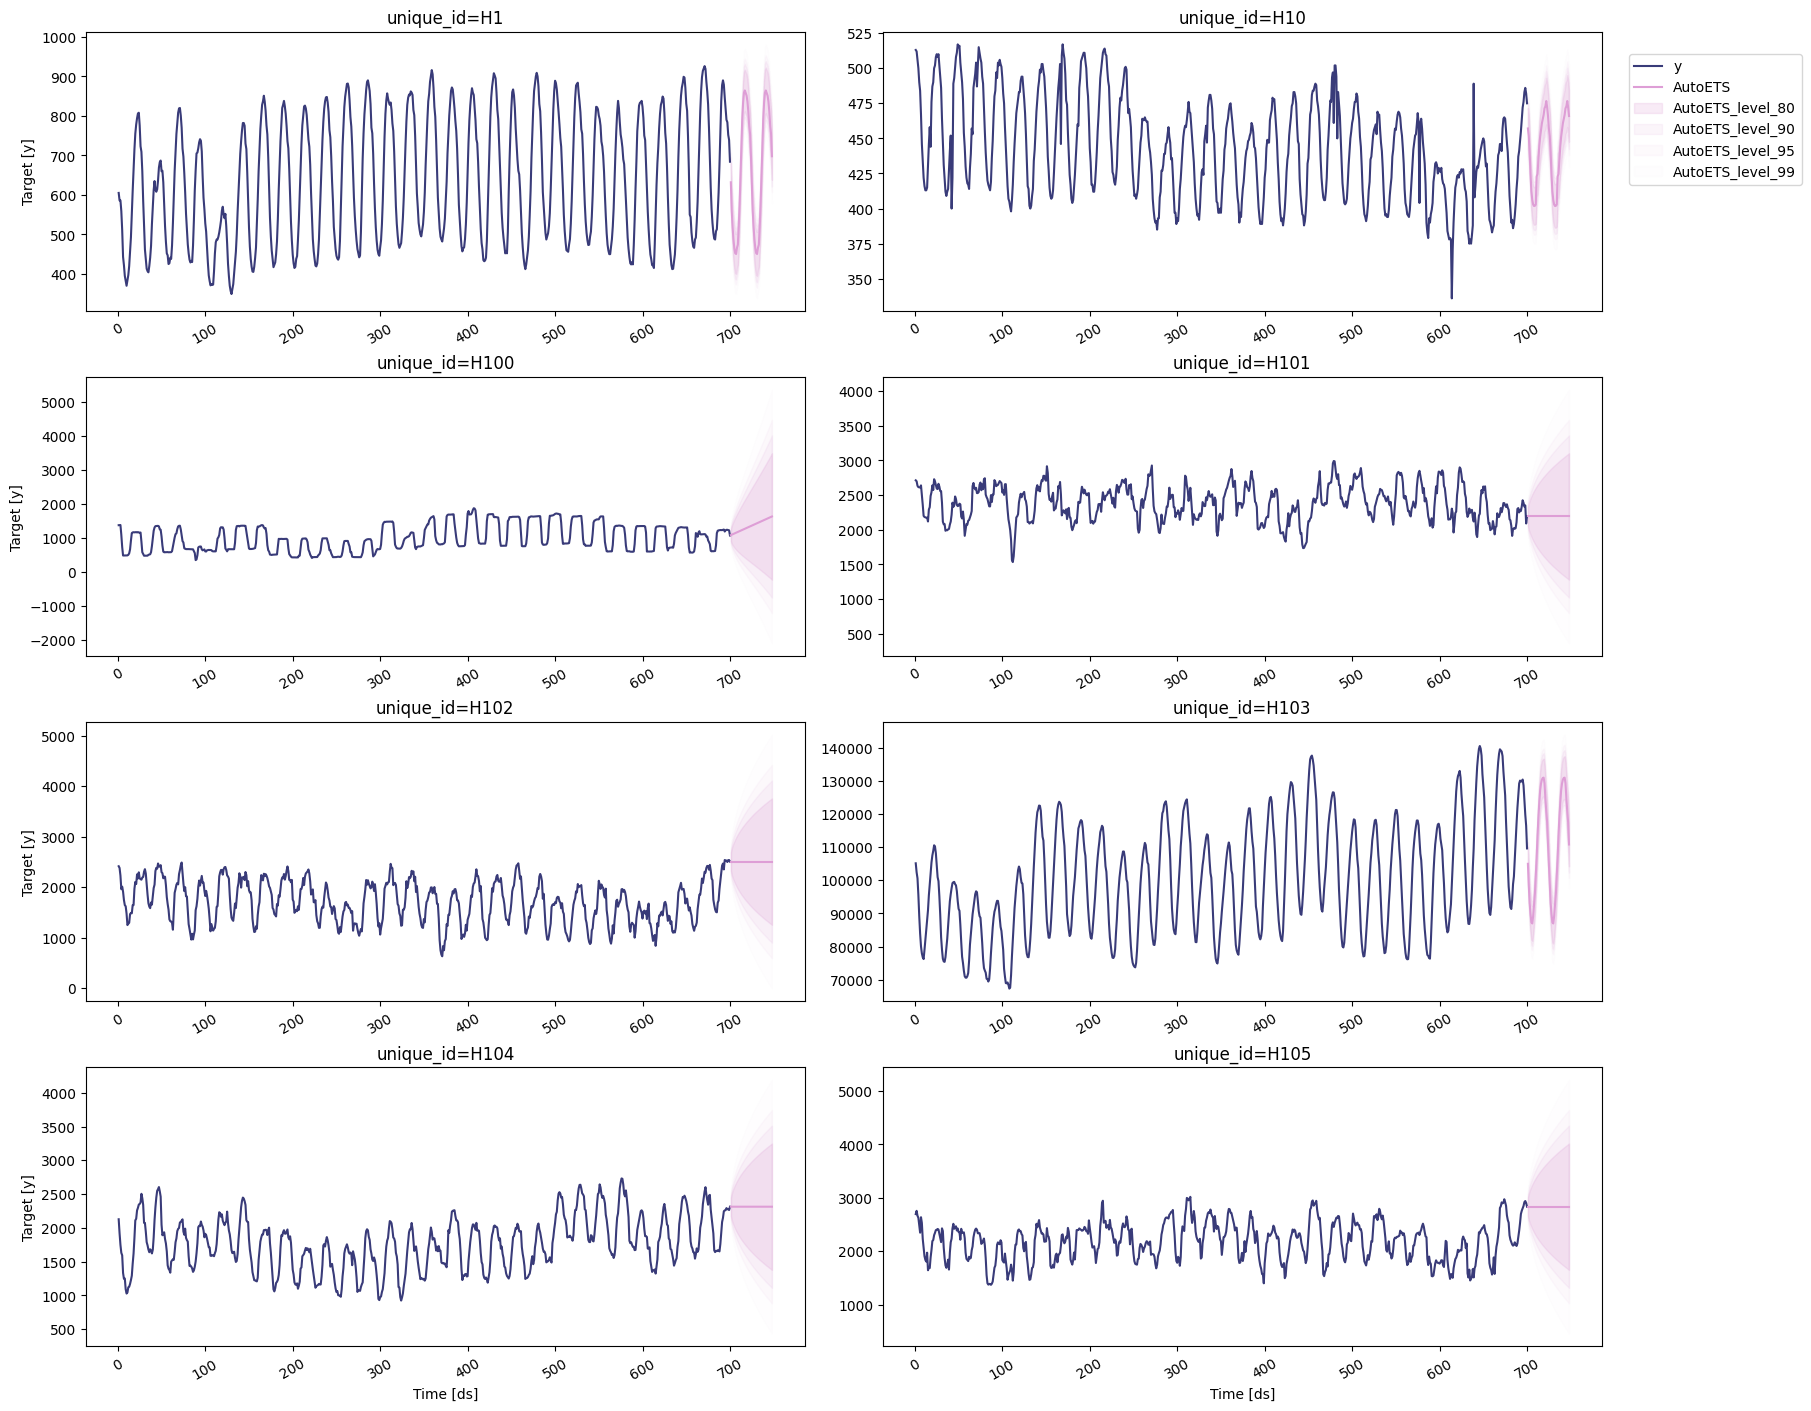

In [101]:
sf.plot(train, test, plot_random = False, models=['AutoETS'], level=levels)

### Historic Average

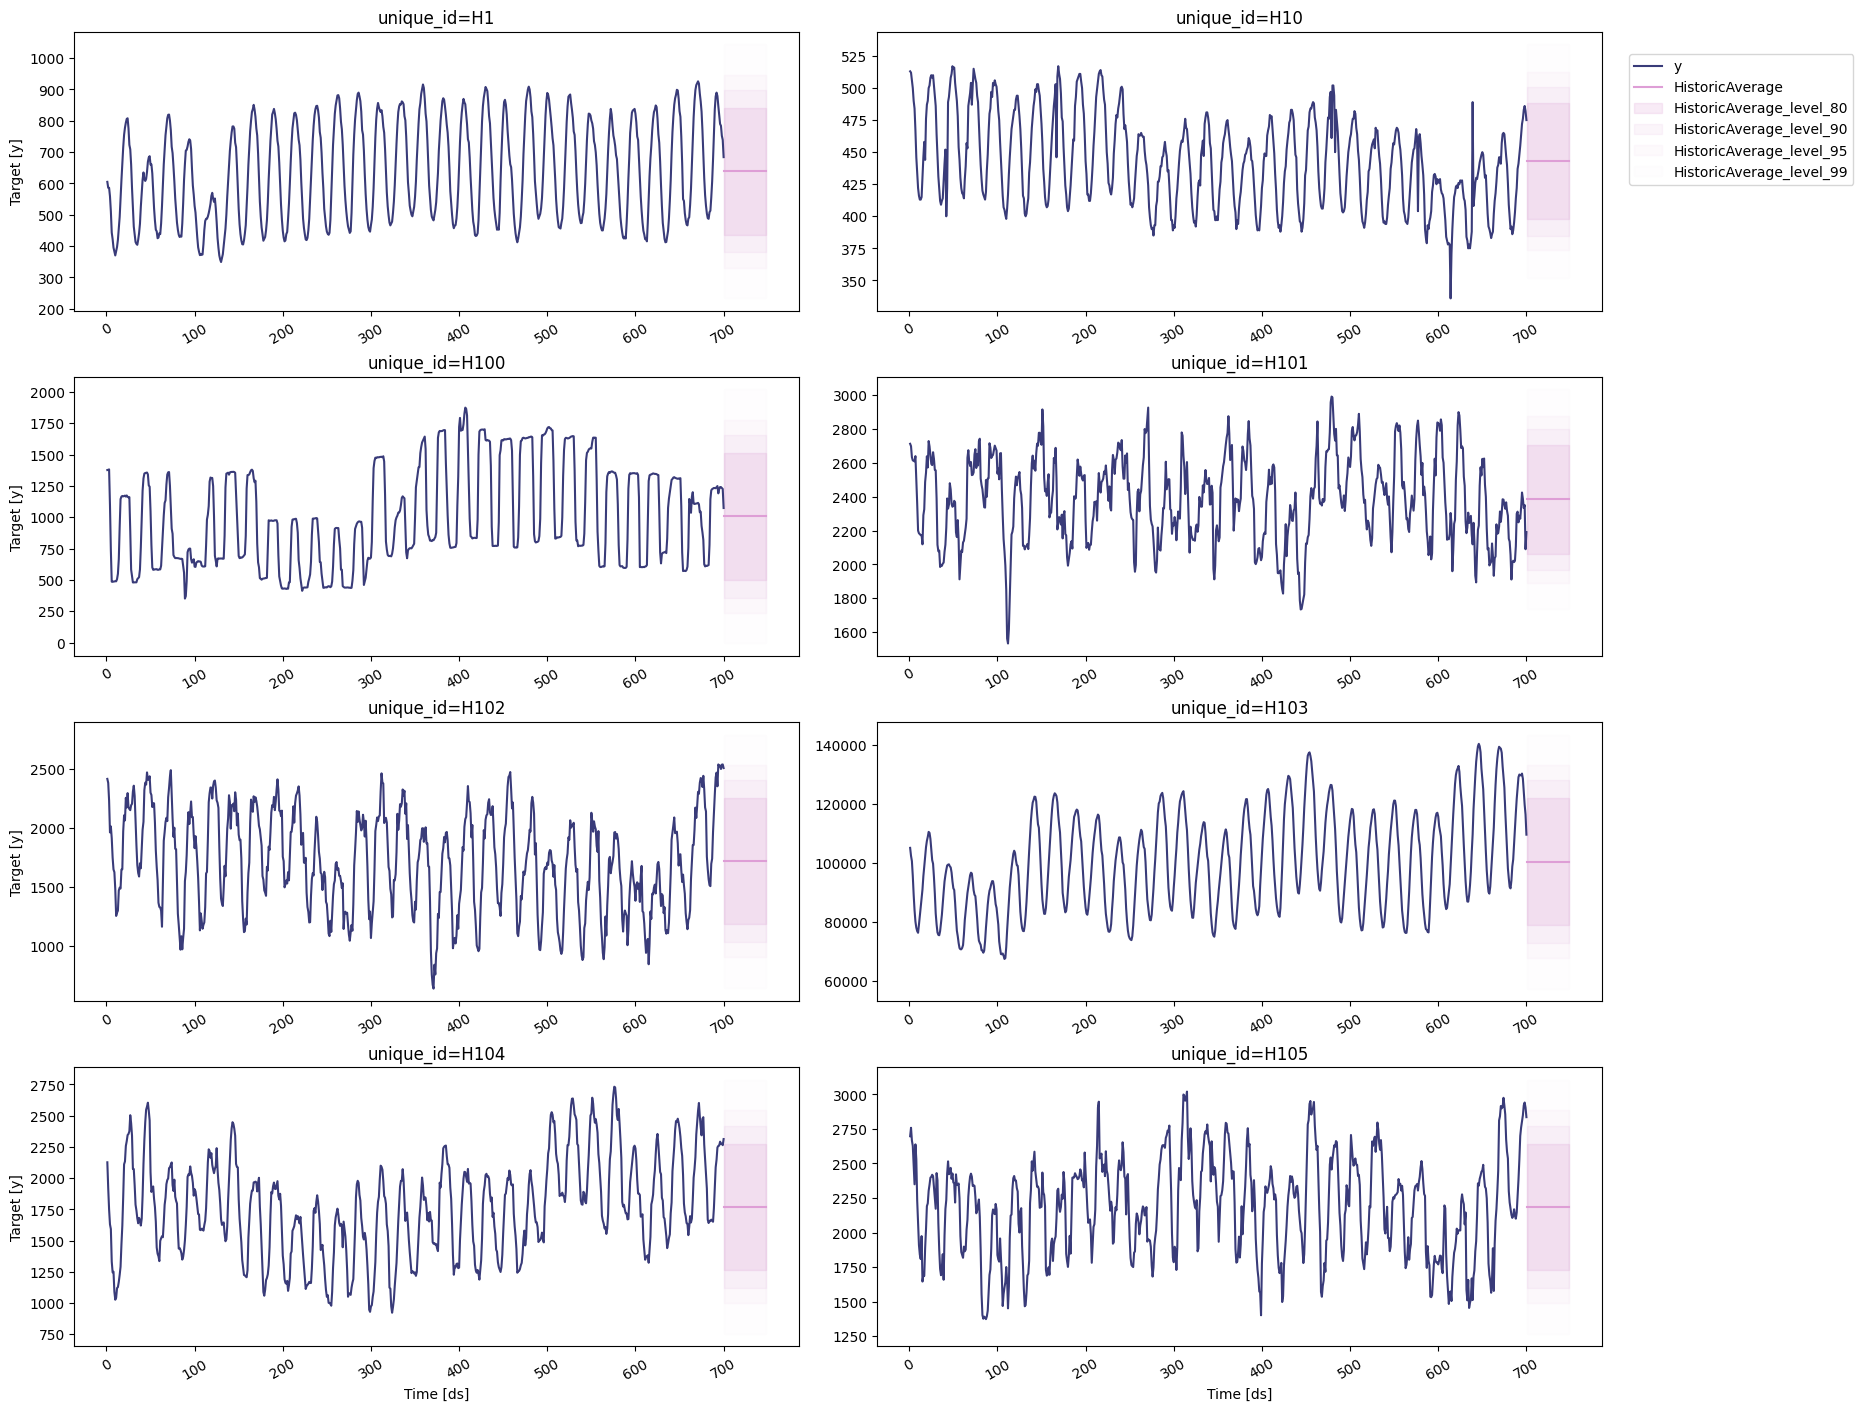

In [103]:
sf.plot(train, test, plot_random = False, models=['HistoricAverage'], level=levels)

### Naïve

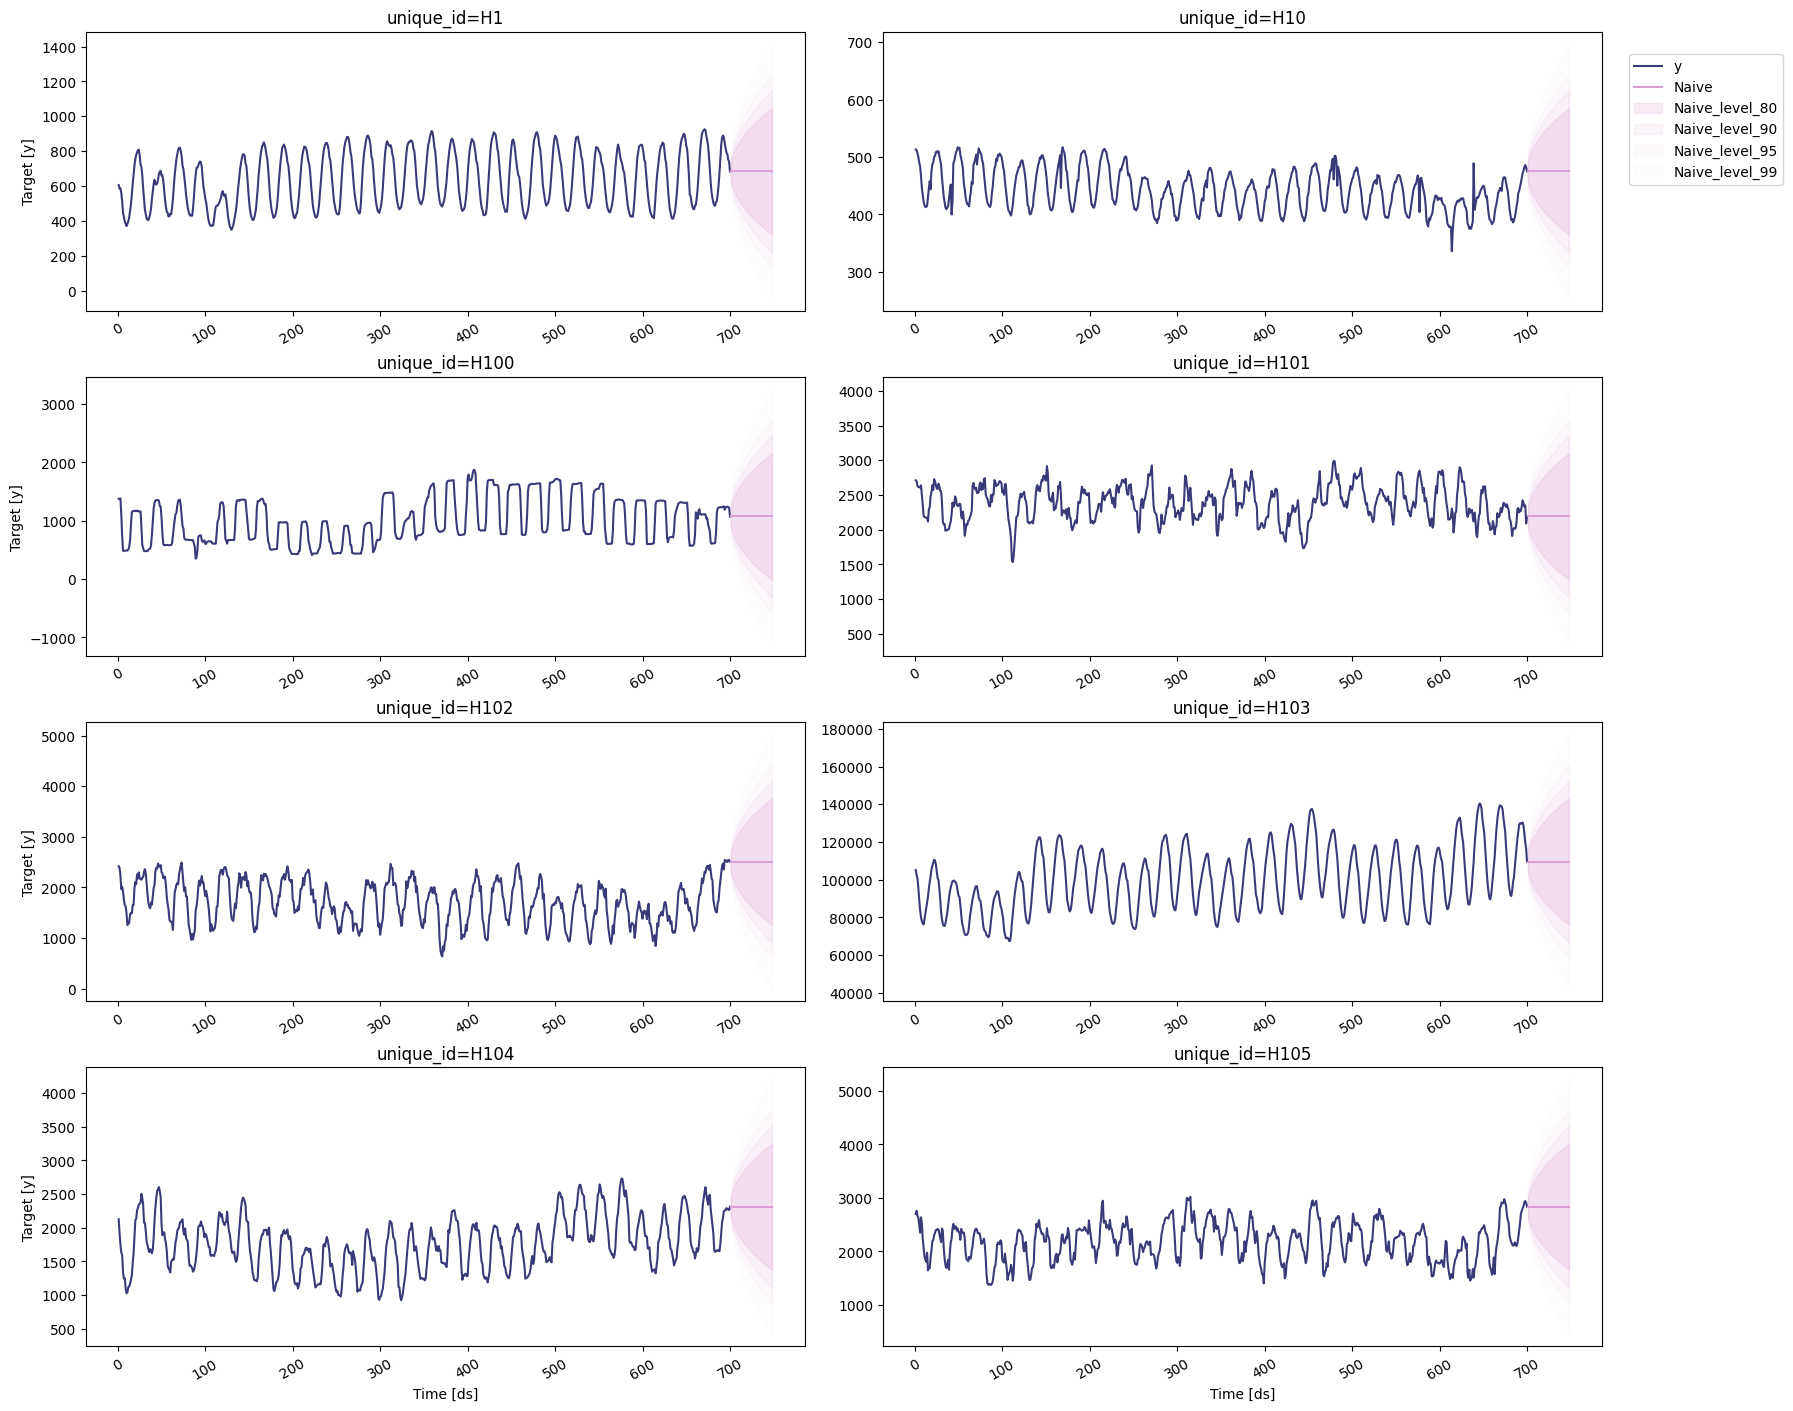

In [105]:
sf.plot(train, test, plot_random = False, models=['Naive'], level=levels)

### Random Walk with Drift

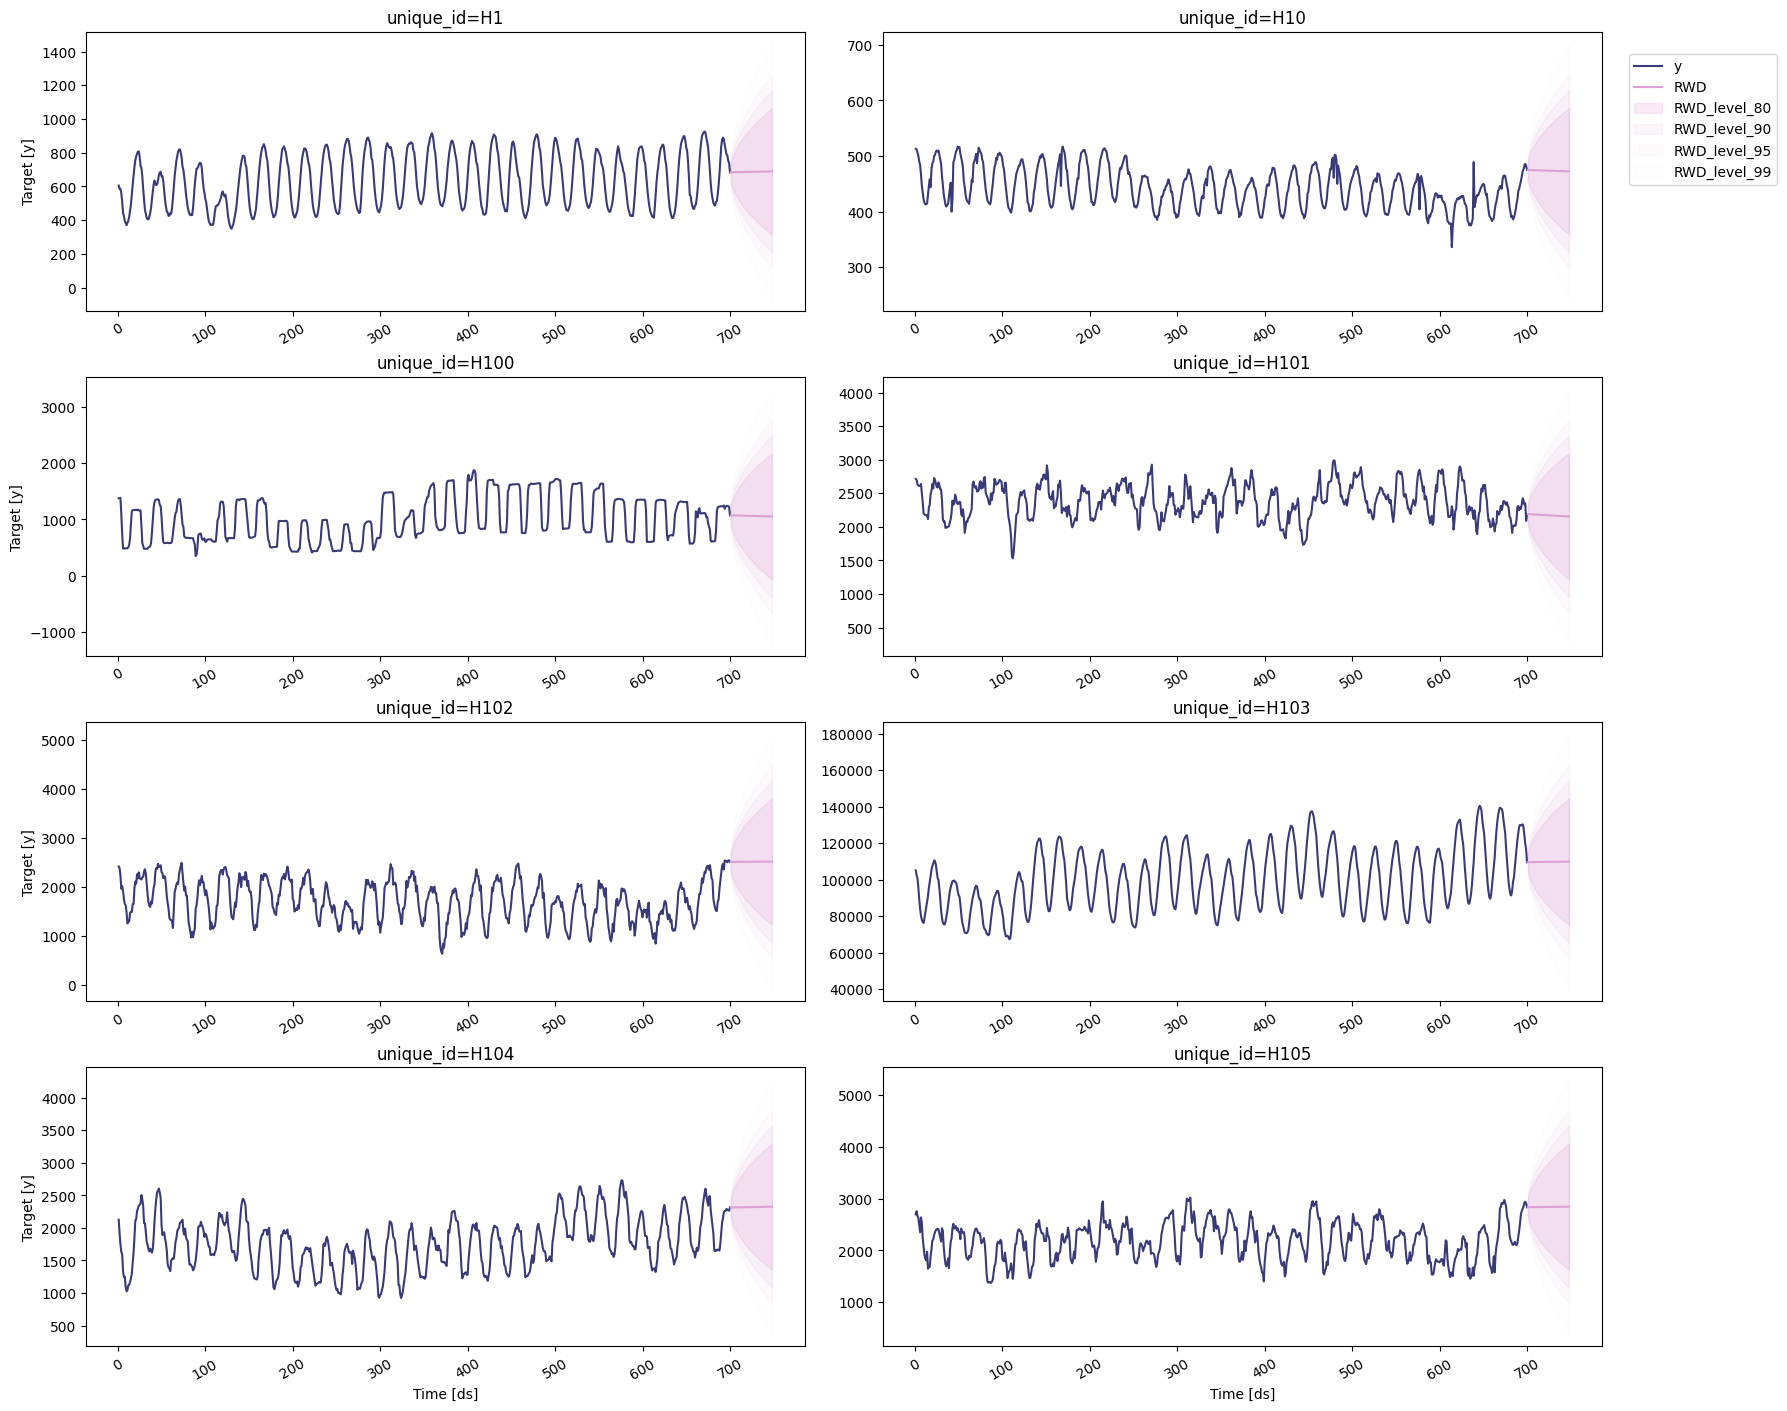

In [107]:
sf.plot(train, test, plot_random = False, models=['RWD'], level=levels)

### Seasonal Naïve

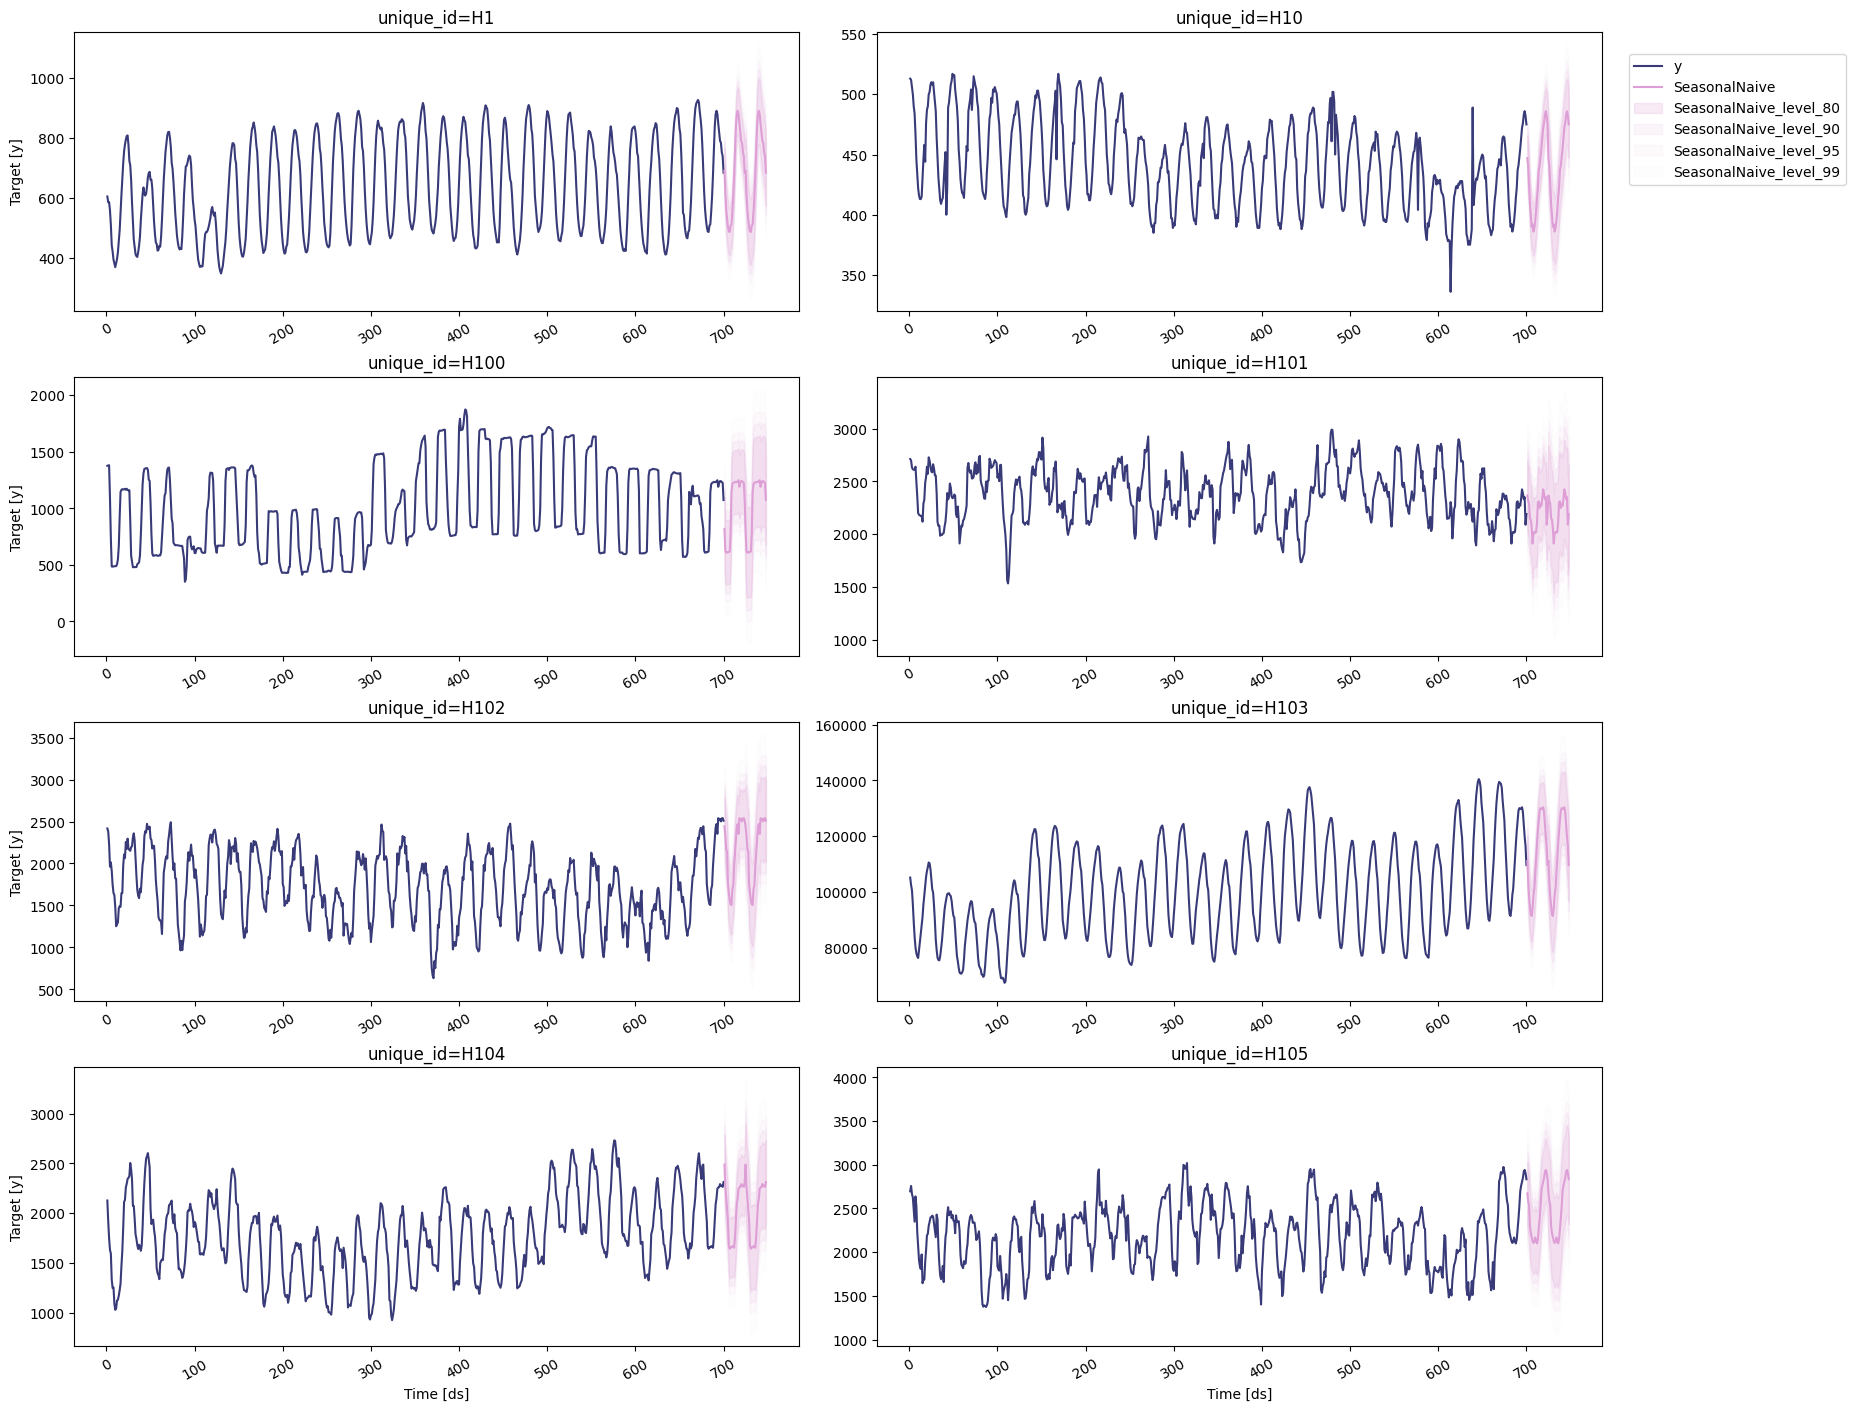

In [109]:
sf.plot(train, test, plot_random = False, models=['SeasonalNaive'], level=levels)

## Conformal Prediction with Nixtla

### Model Training

- Createing a list of: Models & Instantiation Parameters

In [111]:
intervals = ConformalIntervals(h=24, n_windows=2)

models = [
    SeasonalExponentialSmoothing(season_length=24,alpha=0.1, prediction_intervals=intervals),
    ADIDA(prediction_intervals=intervals),
    ARIMA(order=(24,0,12), season_length=24, prediction_intervals=intervals),
]

In [113]:
??ConformalIntervals

Init signature:
ConformalIntervals(
    n_windows: int = 2,
    h: int = 1,
    method: str = 'conformal_distribution',
)
Source:        
class ConformalIntervals:
    """Class for storing conformal intervals metadata information."""

    def __init__(
        self,
        n_windows: int = 2,
        h: int = 1,
        method: str = "conformal_distribution",
    ):
        if n_windows < 2:
            raise ValueError(
                "You need at least two windows to compute conformal intervals"
            )
        allowed_methods = ["conformal_distribution"]
        if method not in allowed_methods:
            raise ValueError(f"method must be one of {allowed_methods}")
        self.n_windows = n_windows
        self.h = h
        self.method = method
File:           ~/venv/lib/python3.10/site-packages/statsforecast/utils.py
Type:           type
Subclasses:     


In [119]:
sf = StatsForecast(
    models=models,
    freq=1, # Changing 'H' to '1'
)

In [123]:
# Prediction Intervals: Confidence Level
levels = [80, 90] 

forecasts = sf.forecast(df=train, h=24, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

index unique_id   ds  SeasonalES  SeasonalES-lo-90  SeasonalES-lo-80  \
0      0        H1  701  624.132703        553.097423        556.359139   
1      1        H1  702  555.698193        496.653559        506.833156   
2      2        H1  703  514.403029        462.673117        464.939840   
3      3        H1  704  482.057899        433.030711        436.161413   
4      4        H1  705  460.222522        414.270186        416.959492   

   SeasonalES-hi-80  SeasonalES-hi-90      ADIDA  ADIDA-lo-90  ADIDA-lo-80  \
0        691.906266        695.167983  638.06397   590.170456   591.823216   
1        604.563231        614.742827  638.06397   490.033337   494.530577   
2        563.866218        566.132941  638.06397   463.370456   466.223216   
3        527.954385        531.085087  638.06397   428.620456   430.723216   
4        503.485552        506.174858  638.06397   404.070456   406.623216   

   ADIDA-hi-80  ADIDA-hi-90       ARIMA  ARIMA-lo-90  ARIMA-lo-80  \
0   684.304725   685.957485  617.782934   609.086733   610.301820   
1   781.597364   786.094604  549.260680   509.888690   514.791630   
2   809.904725   812.757485  508.134119   496.772382   497.299887   
3   845.404725   847.507485  486.933034   471.780520   472.287702   
4   869.504725   872.057485  471.635880   446.563681   448.373713   

   ARIMA-hi-80  ARIMA-hi-90  
0   625.264048   626.479135  
1   583.729731   588.632670  
2   518.968352   519.495856  
3   501.578367   502.085549  
4   494.898046   496.708078

### Plotting: Prediction Intervals

In [125]:
def _plot_fcst(fcst, train, model):
    fig, ax = plt.subplots(1, 1, figsize = (20,7))
    plt.plot(np.arange(0, len(train['y'])), train['y'])
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[model], label=model)
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-lo-90'], color = 'r', label='lo-90')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-hi-90'], color = 'r', label='hi-90')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-lo-80'], color = 'g', label='lo-80')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-hi-80'], color = 'g', label='hi-80')
    plt.legend()

In [127]:
id = "H105"
temp_train = train.loc[train['unique_id'] == id]
temp_forecast = forecasts.loc[forecasts['unique_id'] == id]

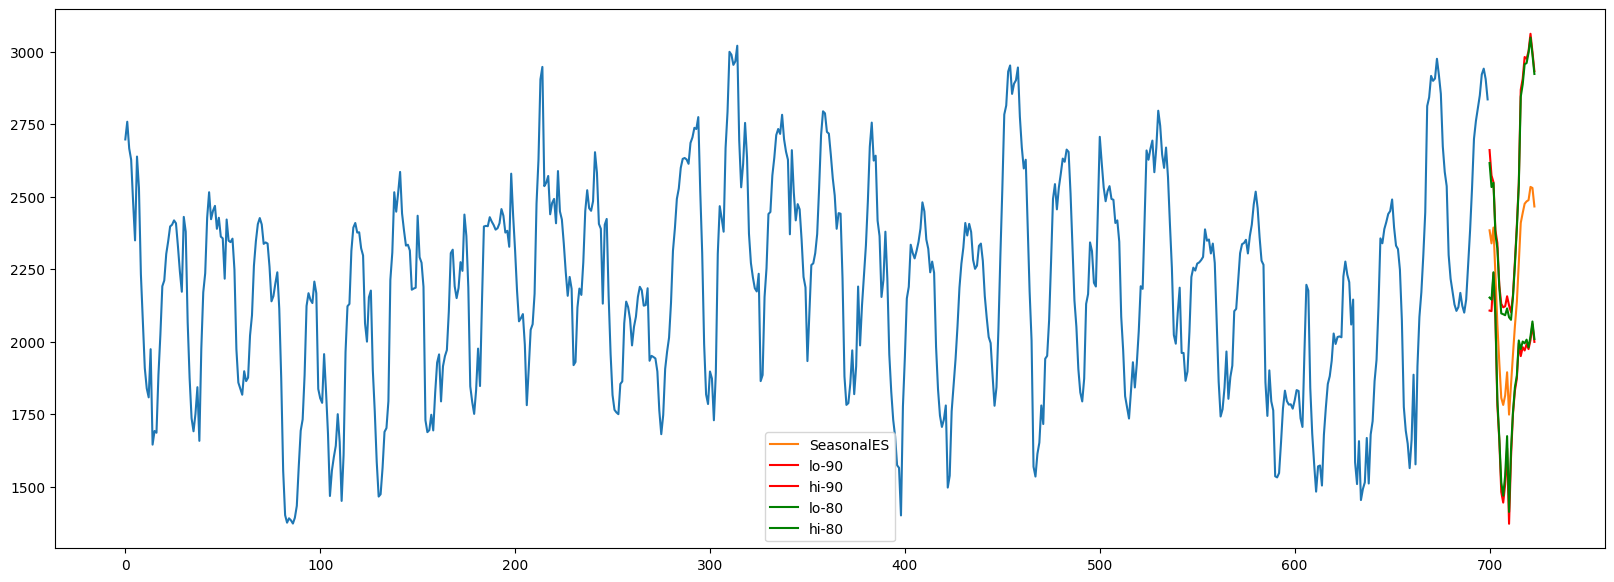

In [129]:
_plot_fcst(temp_forecast, temp_train, "SeasonalES")

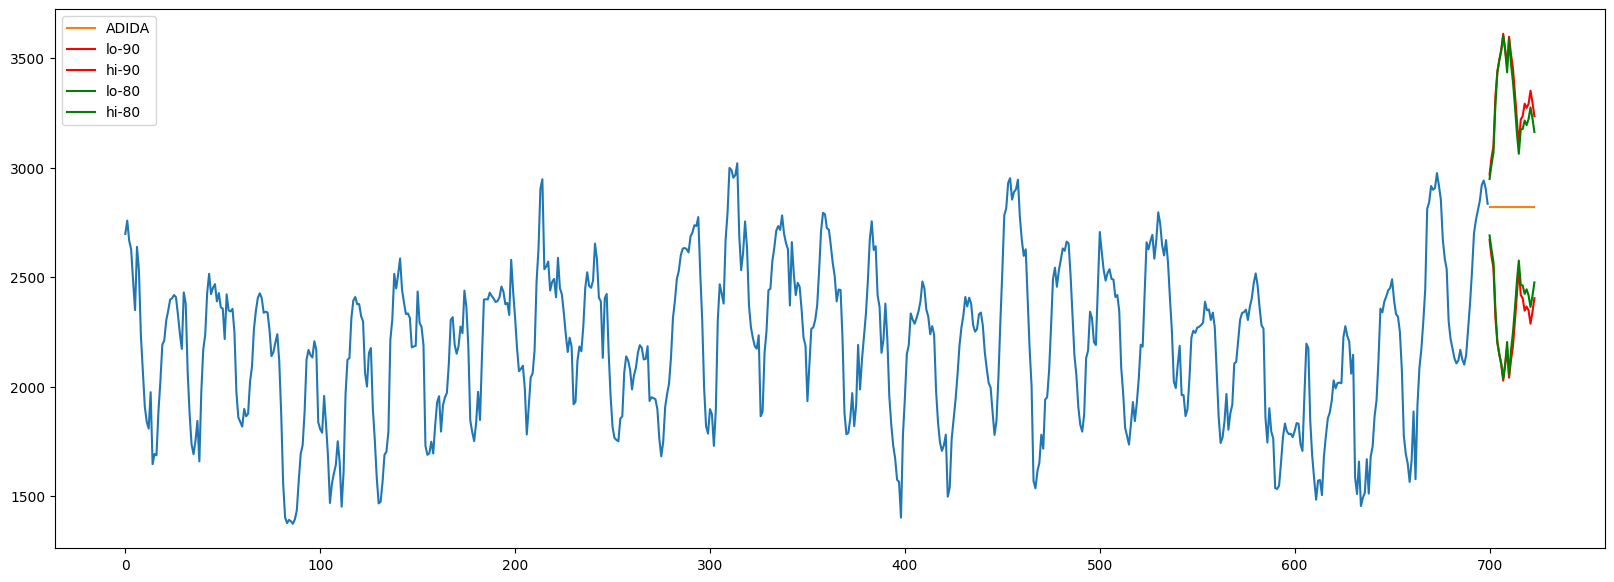

In [131]:
_plot_fcst(temp_forecast, temp_train,"ADIDA")

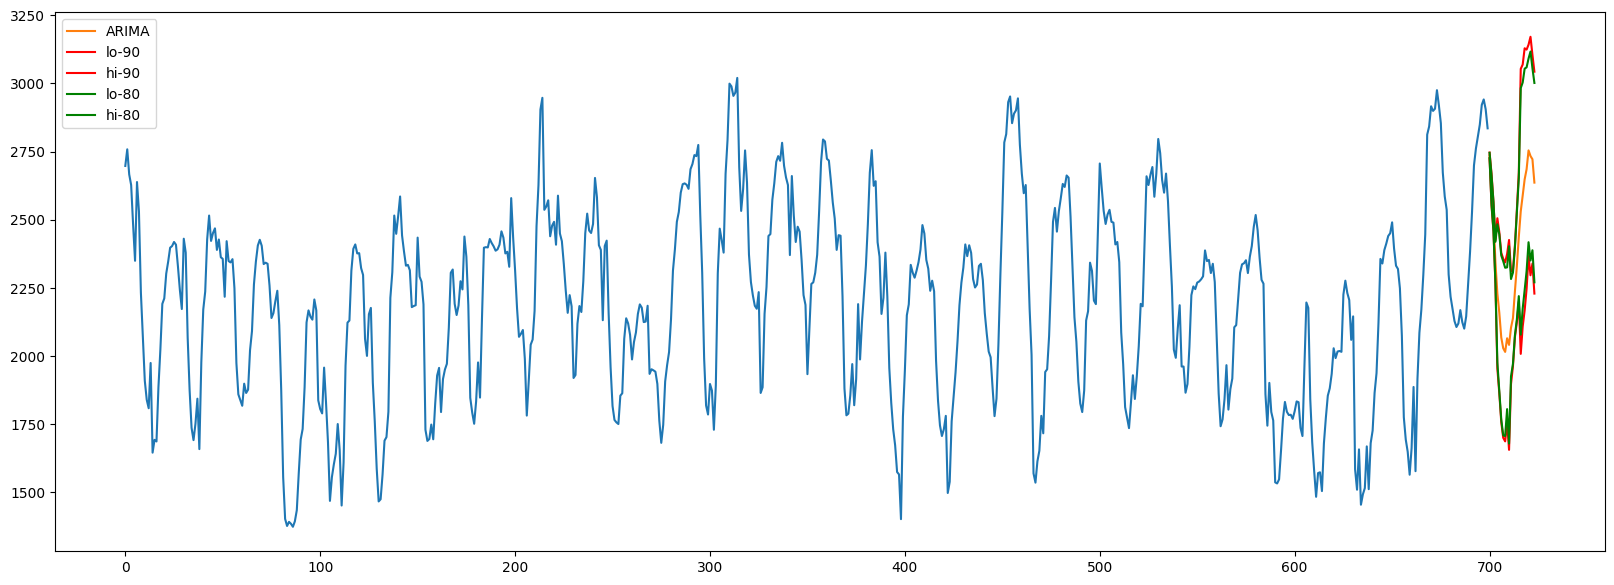

In [133]:
_plot_fcst(temp_forecast, temp_train,"ARIMA")

In [135]:
temp_train

unique_id   ds       y
4900      H105    1  2697.0
4901      H105    2  2758.0
4902      H105    3  2666.0
4903      H105    4  2627.0
4904      H105    5  2482.0
...        ...  ...     ...
5595      H105  696  2849.0
5596      H105  697  2921.0
5597      H105  698  2941.0
5598      H105  699  2905.0
5599      H105  700  2835.0

[700 rows x 3 columns]

In [137]:
temp_forecast

index unique_id   ds   SeasonalES  SeasonalES-lo-90  SeasonalES-lo-80  \
168    168      H105  701  2383.709656       2107.063284       2151.850627   
169    169      H105  702  2338.826615       2105.075200       2144.849767   
170    170      H105  703  2393.279443       2236.917538       2239.134031   
171    171      H105  704  2231.460488       2078.578699       2092.314797   
172    172      H105  705  2060.562047       1781.207894       1799.831577   
173    173      H105  706  1926.845868       1659.951064       1666.560851   
174    174      H105  707  1806.249621       1481.957666       1515.166133   
175    175      H105  708  1781.764925       1445.253108       1469.002486   
176    176      H105  709  1814.698353       1507.487843       1538.390274   
177    177      H105  710  1894.431156       1632.399684       1674.333594   
178    178      H105  711  1748.479088       1372.194691       1413.155753   
179    179      H105  712  1850.870735       1600.280270       1626.500098   
180    180      H105  713  1954.907348       1750.173057       1756.652822   
181    181      H105  714  2053.192694       1830.725182       1842.488010   
182    182      H105  715  2136.817413       1873.055602       1882.829999   
183    183      H105  716  2271.371141       1995.142246       2004.056526   
184    184      H105  717  2409.197103       1950.060246       1974.260300   
185    185      H105  718  2443.519105       1980.946659       2000.325935   
186    186      H105  719  2475.318033       1969.575146       1994.180368   
187    187      H105  720  2483.468929       1991.742874       2006.845301   
188    188      H105  721  2487.828831       1974.293521       1979.981876   
189    189      H105  722  2533.340972       2005.496351       2018.712259   
190    190      H105  723  2529.749929       2060.205090       2069.487499   
191    191      H105  724  2465.933067       1999.185006       2009.186245   

     SeasonalES-hi-80  SeasonalES-hi-90        ADIDA  ADIDA-lo-90  \
168       2615.568685       2660.356028  2819.370526  2670.307688   
169       2532.803464       2572.578031  2819.370526  2593.707688   
170       2547.424855       2549.641347  2819.370526  2541.407688   
171       2370.606178       2384.342276  2819.370526  2313.857688   
172       2321.292516       2339.916199  2819.370526  2199.307688   
173       2187.130885       2193.740672  2819.370526  2146.787969   
174       2097.333109       2130.541575  2819.370526  2101.787969   
175       2094.527363       2118.276741  2819.370526  2027.087969   
176       2091.006431       2121.908863  2819.370526  2099.057688   
177       2114.528718       2156.462628  2819.370526  2174.307688   
178       2083.802422       2124.763484  2819.370526  2040.837969   
179       2075.241373       2101.461201  2819.370526  2120.857688   
180       2153.161874       2159.641640  2819.370526  2184.607688   
181       2263.897379       2275.660206  2819.370526  2298.507688   
182       2390.804828       2400.579224  2819.370526  2418.707688   
183       2538.685757       2547.600037  2819.370526  2540.363723   
184       2844.133906       2868.333959  2819.370526  2418.955500   
185       2886.712276       2906.091551  2819.370526  2402.755500   
186       2956.455697       2981.060919  2819.370526  2346.455500   
187       2960.092557       2975.194984  2819.370526  2365.453083   
188       2995.675786       3001.364141  2819.370526  2347.853083   
189       3047.969685       3061.185593  2819.370526  2287.053083   
190       2990.012360       2999.294768  2819.370526  2340.053083   
191       2922.679888       2932.681128  2819.370526  2403.655500   

     ADIDA-lo-80  ADIDA-hi-80  ADIDA-hi-90        ARIMA  ARIMA-lo-90  \
168  2690.403463  2948.337590  2968.433364  2735.415872  2724.581992   
169  2625.203463  3013.537590  3045.033364  2610.281444  2550.996713   
170  2569.603463  3069.137590  3097.333364  2511.652786  2457.639766   
171  2351.503463  3287.237590  3324.8833

In [143]:
arima_forecast_df = temp_forecast[['unique_id', 'ds', 'ARIMA', 'ARIMA-lo-90', 'ARIMA-hi-90']].head()

In [145]:
temp_train.to_csv('temp_train.csv')

In [147]:
arima_forecast_df.to_csv('arima_forecast_df.csv')

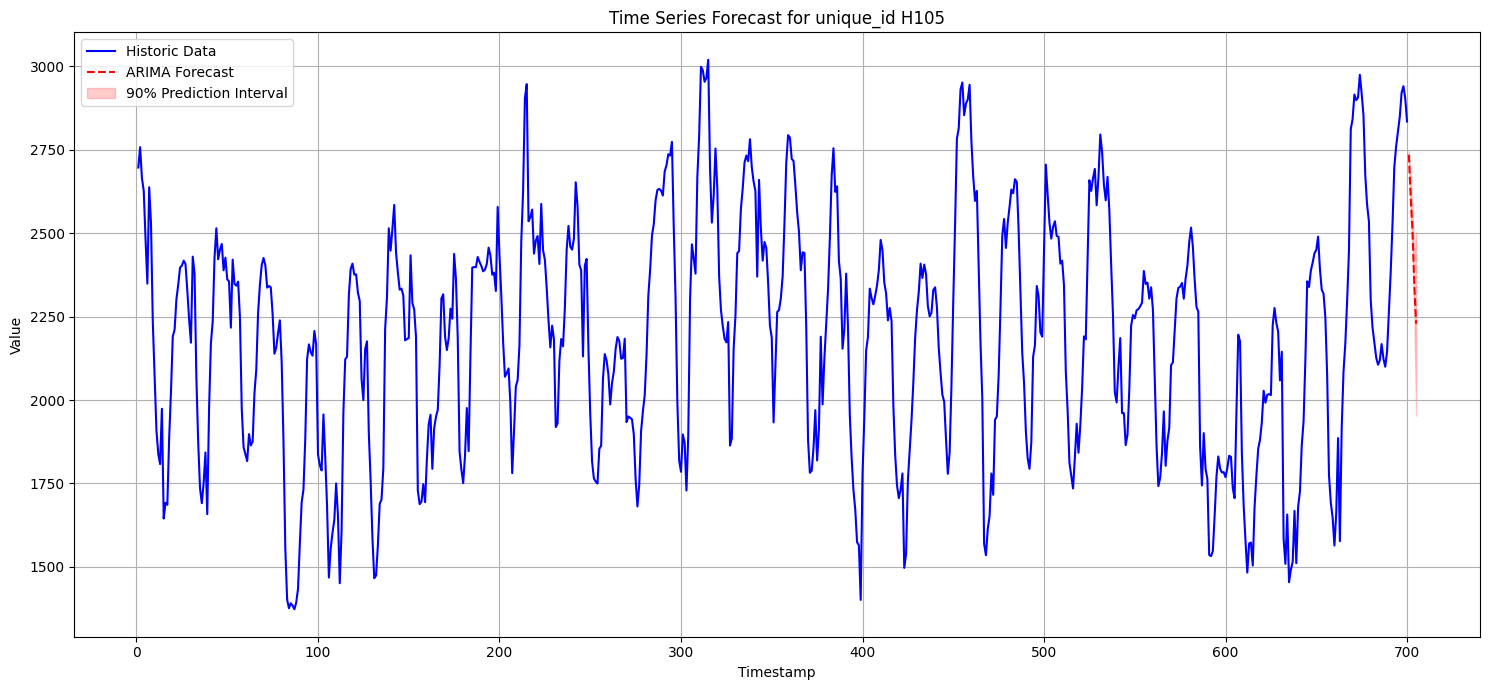

In [149]:
# Sorting for Visualization
temp_train = temp_train.sort_values(by='ds')
arima_forecast_df = arima_forecast_df.sort_values(by='ds')

# Selecting Sample
sample_id = temp_train['unique_id'].iloc[0]

temp_train_sample = temp_train[temp_train['unique_id'] == sample_id]
arima_forecast_sample = arima_forecast_df[arima_forecast_df['unique_id'] == sample_id]

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(temp_train_sample['ds'], temp_train_sample['y'], label='Historic Data', color='blue')
plt.plot(arima_forecast_sample['ds'], arima_forecast_sample['ARIMA'], label='ARIMA Forecast', color='red', linestyle='--')
plt.fill_between(arima_forecast_sample['ds'], arima_forecast_sample['ARIMA-lo-90'], arima_forecast_sample['ARIMA-hi-90'], color='red', alpha=0.2, label='90% Prediction Interval')
plt.legend()
plt.title(f"Time Series Forecast for unique_id {sample_id}")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b98203a-4c5e-4587-9184-9916ad24ee8a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>